In [189]:
#initiate imports

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from datetime import datetime,timezone,timedelta
import json
import math
from scipy.stats import linregress
import cbpro
from IPython.display import clear_output

--------------------------------------------------------------------------------------

--------------------------------------------------------------------------------------

In [190]:
#get my coinbase psscodes
myps=open('../phrase.txt','r').read().splitlines()
public = myps[2].split(':')[1]
passphrase = myps[0].split(':')[1]
secret = myps[1].split(':')[1]

In [191]:
#ticker for crypto
def ticker_update(my_ticker):
    
    auth_client = cbpro.AuthenticatedClient(public,secret,passphrase)
    url = "https://api.exchange.coinbase.com/products/"+my_ticker+"-USD/ticker"

    headers = {"Accept": "application/json"}

    response = requests.request("GET", url, headers=headers)

    return response

In [192]:
#returns current time in proper form
def curr_time():
    a=datetime.now()
    b=str(a+timedelta(hours=2))
    c=b.split(" ")
    d=c[1].split(":")
    
    return c[0]+'T'+d[0]+':'+d[1]+':'+d[2].split(".")[0]

In [193]:
def start_time():
    
    days=10
    
    a=datetime.now()
    b=str(a-timedelta(days=10))
    c=b.split(" ")
    d=c[1].split(":")
    
    return c[0]+'T'+d[0]+':'+d[1]+':'+d[2].split(".")[0]

In [194]:
#this will use linear regression to try and weed out spikes
def find_starting_point(df):
    stable_currency=True #assumes currency is stable at the start
    start_point=len(df)-300
    window=df.iloc[start_point:len(df)]
    x = np.arange(0,len(window))
    y = window.Close
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    slope

    #go backwards until slope is less than .5 (absolute value)
    while (abs(slope)>.5 and start_point>0):
        start_point=start_point-5
        window=df.iloc[start_point:len(df)]
        #print(start_point)
        x = np.arange(0,len(window))
        y = window.Close
        slope, intercept, r_value, p_value, std_err = linregress(x, y)

    #checks to make sure the condition has been met
    if (start_point<0 and abs(slope)>.5):
        #condition has not been met
        stable_currency=False

    #now fine tune the start point if conditions have been met
    if (stable_currency==True):
        old_slope=slope
        #print(start_point)
        while (abs(old_slope)>=abs(slope) and start_point>0): #need to add an or if the slope never makes it
            old_slope=slope
            start_point=start_point-5
            window=df.iloc[start_point:len(df)]
            x = np.arange(0,len(window))
            y = window.Close
            slope, intercept, r_value, p_value, std_err = linregress(x, y)
            #print(f'slope: {slope}')
            #print(f'old slope: {old_slope}')

        #add 10 to start_point to negate the final 10 taken off in the last step
        start_point=start_point+10
        window=df.iloc[start_point:len(df)]       

        #makes sure the most recent price is aligned with the generated window  
        
        last_value=window.iloc[len(window)-1:].Close[0]
        mean_value=window.Close.mean()

        if (last_value<=mean_value):
            check_percent=(last_value/mean_value)
        else:
            check_percent=(mean_value/last_value)

        if (check_percent<.96):
            print('the current price is too far of the window mean')
            stable_currency=False

    if (stable_currency):
        #conditions have been met so return
        print (f'start point: {start_point}')
        print (f'check percent: {check_percent}')
        return start_point
    else:
        print('the conditions have not been met so leave currency out this time')
        start_point=-1
        return start_point
        
   
    

    

In [195]:
#outputs graph
def output_graph(df,start_point):
    
    #plot the entire graph
    x1 = np.arange(0,len(df))
    y1 = df.Close
    
    #plot truncated graph where the slope is less than .05
    window=df.iloc[start_point:]
    x2 = np.arange(len(df)-len(window),len(df))
    y2 = window.Close
    slope, intercept, r_value, p_value, std_err = linregress(x2, y2)
    predict_line=slope*(len(window)+1)+intercept  
    regress_values=x2*slope+intercept
    
    #plot the mean for the second graph
    a=[len(df)-len(window),len(df)]   
    b=y2.mean()

    print(slope)
    print(f' max: {window.Close.max()}')
    print(f' mean: {window.Close.mean()}')
    print(f' min: {window.Close.min()}')

    
    return [x1,y1,x2,y2,a,b,regress_values]

In [196]:
#!!!!!!!!!!!!!!!!!!!!  RUN THIS FOR HISTORIAL COINBASE  !!!!!!!!!!!!!!!!!!!!
def coinbase_historical(crypto):
    #COINBASE
    #exchange history 20210404T040404Z
    #four hours behind
    request_num=0
    #create my client
    auth_client = cbpro.AuthenticatedClient(public,secret,passphrase)
    c = cbpro.PublicClient()

    #change these to modify
    the_start=start_time()
    finish_date=curr_time()

    #breaks it down to 1 hour searches
    the_end=str(pd.to_datetime(the_start)+timedelta(hours=10))

    #run through it once
    historical = pd.DataFrame(c.get_product_historic_rates(product_id=crypto, start=the_start,
                                                           end=the_end, granularity=300))
    
    #getting an error in the line below if historical is returning with 0 axis?
    historical.columns= ["Date","Open","High","Low","Close","Volume"]
    historical['Date'] = pd.to_datetime(historical['Date'], unit='s')
    historical.set_index('Date', inplace=True)
    historical.sort_values(by='Date', ascending=True, inplace=True)

    #loop through until finish is met
    date_reached=False
    while date_reached==False:
        if (historical.iloc[-1].name<pd.to_datetime(finish_date)):
                the_start=(historical.iloc[-1].name+timedelta(minutes=5))
                the_end=(historical.iloc[-1].name+timedelta(hours=10))
                new_df=pd.DataFrame(c.get_product_historic_rates(product_id=crypto, start=str(the_start),
                                                                 end=str(the_end), granularity=300))
                new_df.columns= ["Date","Open","High","Low","Close","Volume"]
                new_df['Date'] = pd.to_datetime(new_df['Date'], unit='s')
                new_df.set_index('Date', inplace=True)
                new_df.sort_values(by='Date', ascending=True, inplace=True)
                historical=pd.concat([historical, new_df])
                my_df_lenght=len(historical)
                #print(f'request: {request_num} and new df lenght is {my_df_lenght}')
                request_num=request_num+1
        else:
            date_reached=True
    
    ticker=float(ticker_update(crypto.split('-')[0]).json()['price']) 
    historical.loc[finish_date]=[ticker,ticker,ticker,ticker,ticker]
            
    return historical

start point: 1512
check percent: 0.9862106334041049
-0.00733274147490529
 max: 79.54
 mean: 74.32083333333334
 min: 70.65


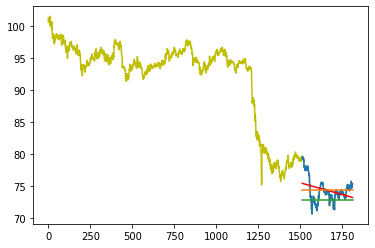

In [127]:
#run this for a single selected currency
#I would like to have this show 10 days + worth but show this line as where it starts the mean
df=coinbase_historical('AXS-USDT')
start_point=find_starting_point(df)
x1,y1,x2,y2,a,b,regress_values=output_graph(df,start_point)


adjust=.99*.99
plt.plot(x1,y1,'-y')
plt.plot(x2,y2)
plt.plot(x2,regress_values,'-r')
plt.plot(a,[b,b])
plt.plot(a,[b*adjust,b*adjust])
plt.show()

In [52]:
df

,Open,High,Low,Close,Volume
Date,,,,,
2021-12-26 20:35:00,9.35,9.43,9.43,9.35,20.331
2021-12-26 21:10:00,9.35,9.37,9.35,9.37,14.707
2021-12-26 21:15:00,9.37,9.39,9.37,9.39,20.337
2021-12-26 21:35:00,9.37,9.39,9.39,9.38,178.326
2021-12-26 21:50:00,9.39,9.40,9.39,9.40,80.995
...,...,...,...,...,...
2022-01-06 03:15:00,8.98,9.00,8.98,8.98,139.552
2022-01-06 03:20:00,8.94,8.98,8.98,8.94,183.902
2022-01-06 03:45:00,8.86,8.89,8.89,8.86,22.950


In [9]:
ticker=float(ticker_update('TRU').json()['price']) 
print(ticker)
df.append({'Open':ticker,'High':ticker,'Low':ticker,'Close':ticker,'Volume':ticker}, ignore_index=False)
df

0.3195


NameError: name 'df' is not defined

-1.1628594705258588e-05


0.08951741437610206

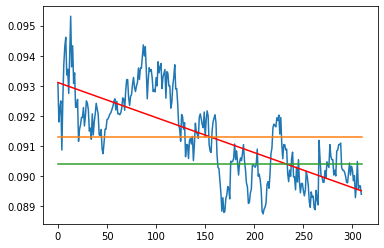

In [21]:
window=df.iloc[0:]
x = np.arange(0,len(window))
y = window.Close
slope, intercept, r_value, p_value, std_err = linregress(x, y)
predict_line=slope*(len(window)+1)+intercept  
regress_values=x*slope+intercept

plt.plot(x,y)
plt.plot(x,regress_values,'-r')
print(slope)

a=[0,len(x)]
b=[y.mean(),y.mean()]
plt.plot(a,b)

a=[0,len(x)]
b=[y.mean()*.99,y.mean()*.99]
plt.plot(a,b)

#df=df.iloc[0:]
regress_values[len(regress_values)-1]

In [388]:
window=df.iloc[427:]
x = np.arange(0,len(window))
y = window.Close
slope, intercept, r_value, p_value, std_err = linregress(x, y)
predict_line=slope*(len(window)+1)+intercept  
regress_values=x*slope+intercept
print(slope)

0.19563210355570088


In [161]:
currency_pool

[{'CRYPTO': 'REQ',
  'BUY-PRICE': 0.29979702666666663,
  'bought': 0,
  'sell': 0,
  'hold': 0},
 {'CRYPTO': 'AUCTION',
  'BUY-PRICE': 21.157967457627116,
  'bought': 0,
  'sell': 0,
  'hold': 0},
 {'CRYPTO': 'SOL',
  'BUY-PRICE': 138.88523457627122,
  'bought': 0,
  'sell': 0,
  'hold': 0},
 {'CRYPTO': 'DOGE',
  'BUY-PRICE': 0.15203122033898303,
  'bought': 0,
  'sell': 0,
  'hold': 0},
 {'CRYPTO': 'LCX',
  'BUY-PRICE': 0.16066917288135593,
  'bought': 0,
  'sell': 0,
  'hold': 0},
 {'CRYPTO': 'ETH',
  'BUY-PRICE': 3138.479233898305,
  'bought': 0,
  'sell': 0,
  'hold': 0},
 {'CRYPTO': 'ICP',
  'BUY-PRICE': 31.460890169491524,
  'bought': 0,
  'sell': 0,
  'hold': 0},
 {'CRYPTO': 'BTC',
  'BUY-PRICE': 41001.19292677966,
  'bought': 0,
  'sell': 0,
  'hold': 0},
 {'CRYPTO': 'COVAL',
  'BUY-PRICE': 0.11074698645161292,
  'bought': 0,
  'sell': 0,
  'hold': 0},
 {'CRYPTO': 'KRL',
  'BUY-PRICE': 1.2608490644067798,
  'bought': 0,
  'sell': 0,
  'hold': 0},
 {'CRYPTO': 'CRO',
  'BUY-PRICE

In [174]:
currency_pool

[{'CRYPTO': 'ICP',
  'BUY-PRICE': 31.43361245901639,
  'bought': 0,
  'sell': 0,
  'hold': 0},
 {'CRYPTO': 'PERP',
  'BUY-PRICE': 8.701632164948453,
  'bought': 0,
  'sell': 0,
  'hold': 0},
 {'CRYPTO': 'BTC',
  'BUY-PRICE': 41147.99836630769,
  'bought': 0,
  'sell': 0,
  'hold': 0}]

DDX
the current price is too far of the window mean
the conditions have not been met so leave currency out this time
DOGE
start point: 1391
check percent: 0.9803125957707632
1.9371821089612525e-06
 max: 0.1645
 mean: 0.14763507692307695
 min: 0.1381


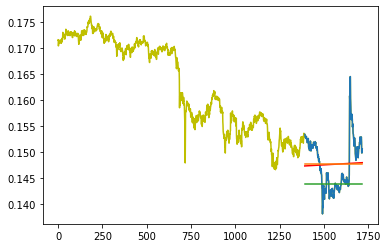

FET
start point: 1793
check percent: 0.9644249498502778
-1.3711004328437737e-05
 max: 0.477
 mean: 0.44980779661016956
 min: 0.418


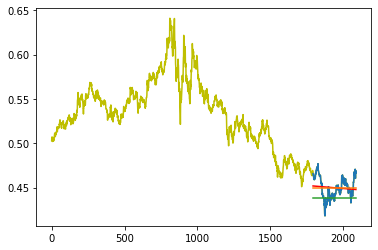

ALCX
start point: 1619
check percent: 0.9713563669955801
-0.08032065496835473
 max: 296.9
 mean: 276.4188813559322
 min: 255.11


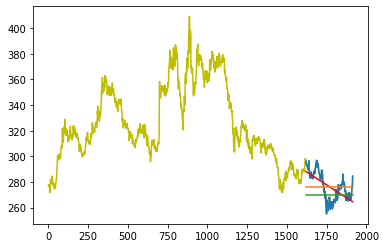

SHIB
start point: 2558
check percent: 0.9680668368530982
2.7609833810495833e-09
 max: 2.82e-05
 mean: 2.6912258064516133e-05
 min: 2.62e-05


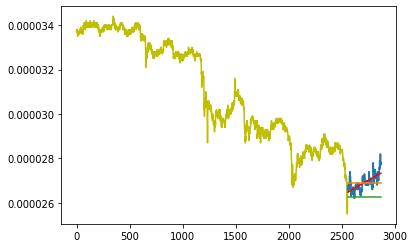

POLS
start point: 242
check percent: 0.9765050314835519
-0.0011285536660839317
 max: 2.6
 mean: 2.304135593220339
 min: 2.05


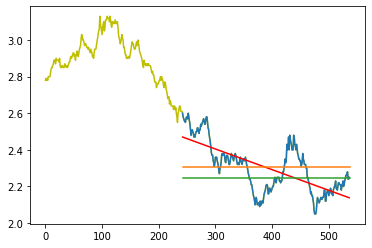

SPELL
start point: 2027
check percent: 0.9659046117461569
-9.223872783194819e-07
 max: 0.01512
 mean: 0.014121525423728814
 min: 0.01331


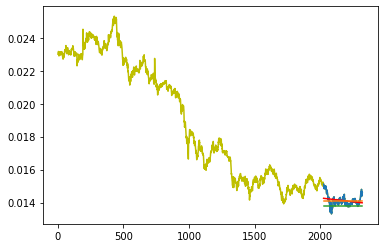

GALA
start point: 2032
check percent: 0.9681287192642617
4.190829407631793e-06
 max: 0.32388
 mean: 0.30820377777777774
 min: 0.29394


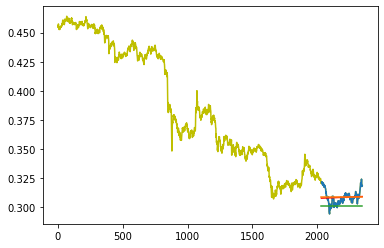

SUKU
the current price is too far of the window mean
the conditions have not been met so leave currency out this time
CRO
start point: 1594
check percent: 0.9913189441316717
-5.366491534772409e-05
 max: 0.4713
 mean: 0.4524379661016949
 min: 0.4295


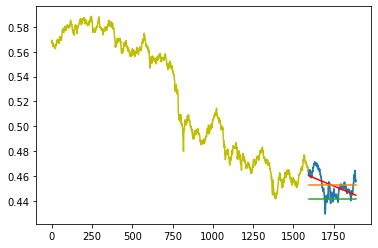

ASM
start point: 985
check percent: 0.99833733575431
-2.6483289373154728e-05
 max: 0.08718
 mean: 0.0811648253968254
 min: 0.07488


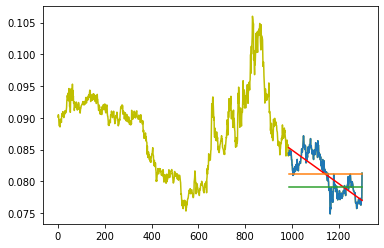

PERP
the current price is too far of the window mean
the conditions have not been met so leave currency out this time
REQ
start point: 1577
check percent: 0.9854341132607985
-5.5799625118027064e-05
 max: 0.30502
 mean: 0.2850072542372881
 min: 0.27163


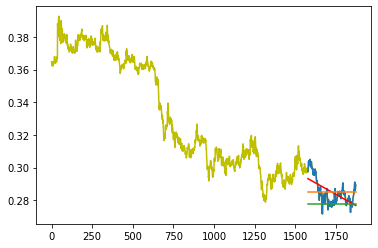

IDEX
start point: 646
check percent: 0.9696269203071594
-8.492112123411004e-05
 max: 0.2304
 mean: 0.21204031746031746
 min: 0.1936


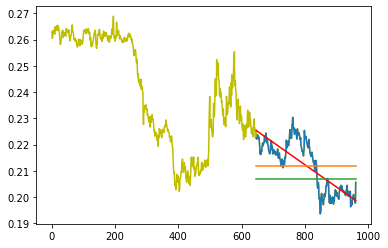

TRAC
the current price is too far of the window mean
the conditions have not been met so leave currency out this time
BADGER
start point: 881
check percent: 0.9983047431925236
-0.0012453223963155185
 max: 12.54
 mean: 12.009606060606059
 min: 11.15


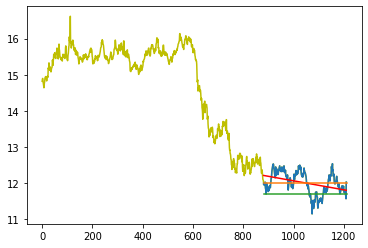

BTC
start point: 2427
check percent: 0.9841271909005539
0.08735397412282883
 max: 42998.13
 mean: 41825.41545454545
 min: 39762.39


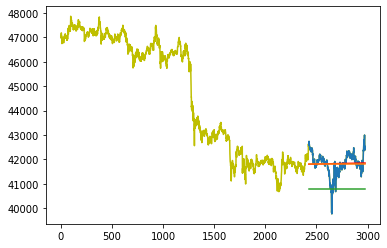

MCO2


/opt/anaconda3/envs/PythonData/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/opt/anaconda3/envs/PythonData/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/opt/anaconda3/envs/PythonData/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


the current price is too far of the window mean
the conditions have not been met so leave currency out this time
ARPA
start point: 286
check percent: 0.9726773995486766
-4.022614451185879e-05
 max: 0.0929
 mean: 0.08502305084745763
 min: 0.0772


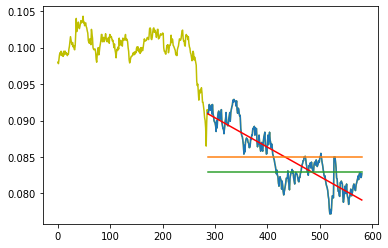

KRL
start point: 1067
check percent: 0.9997601599664498
-0.00024312965681004407
 max: 1.2824
 mean: 1.2364033898305085
 min: 1.1976


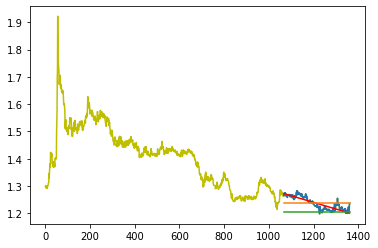

COVAL
start point: 1631
check percent: 0.9926598689885899
1.5110939112487072e-06
 max: 0.11679
 mean: 0.10997678688524588
 min: 0.10263


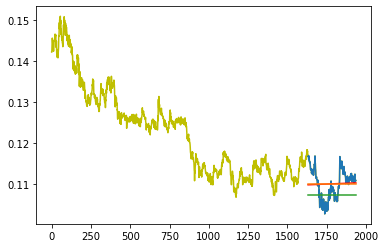

AGLD
the current price is too far of the window mean
the conditions have not been met so leave currency out this time
MDT
start point: 1194
check percent: 0.9656701036615984
-4.115317092967522e-05
 max: 0.10137
 mean: 0.09320988571428569
 min: 0.08412


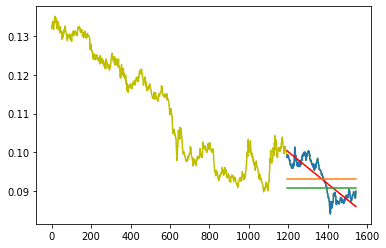

CLV
start point: 102
check percent: 0.9691084087372485
-0.00031478399880336896
 max: 0.7
 mean: 0.5881694915254237
 min: 0.54


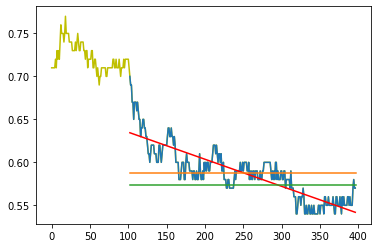

WLUNA
the current price is too far of the window mean
the conditions have not been met so leave currency out this time
TRU
start point: 721
check percent: 0.9901389124838282
-4.019791150541757e-05
 max: 0.271
 mean: 0.25684203389830507
 min: 0.2372


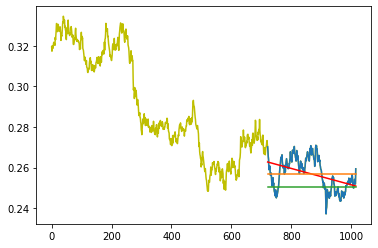

AUCTION
start point: 752
check percent: 0.9998632389627253
-0.004165443548010133
 max: 21.78
 mean: 20.572813559322032
 min: 18.99


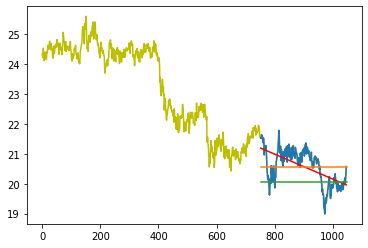

RLY
start point: 304
check percent: 0.9787991985641534
-0.00012756256602503572
 max: 0.3164
 mean: 0.28575830508474576
 min: 0.2613


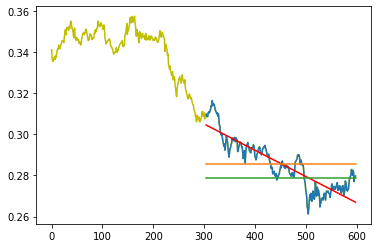

LCX
the current price is too far of the window mean
the conditions have not been met so leave currency out this time
VGX
start point: 208
check percent: 0.9952432041156624
-0.0008512391672197967
 max: 2.9
 mean: 2.6224745762711867
 min: 2.38


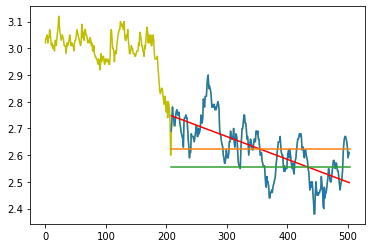

ORN
start point: 618
check percent: 0.978196777035511
-0.0015348004524759968
 max: 5.21
 mean: 4.8865423728813555
 min: 4.46


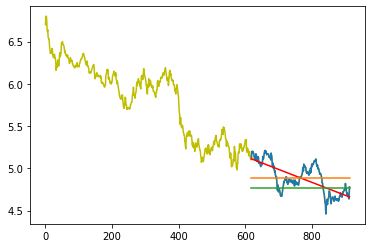

XYO
start point: 1451
check percent: 0.9748770257597303
-1.2095688389877258e-06
 max: 0.03025
 mean: 0.028596067796610173
 min: 0.026776


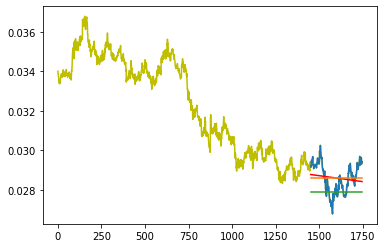

BICO
start point: 1768
check percent: 0.9918835044163286
-0.00017990595230304695
 max: 3.74
 mean: 3.5211864406779663
 min: 3.34


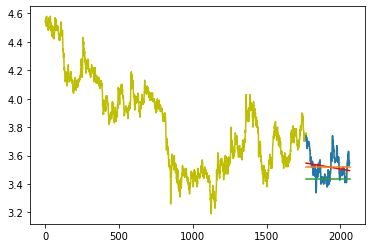

ETH
start point: 2674
check percent: 0.9635861453778038
0.4349988844320491
 max: 3262.79
 mean: 3100.2517
 min: 2976.92


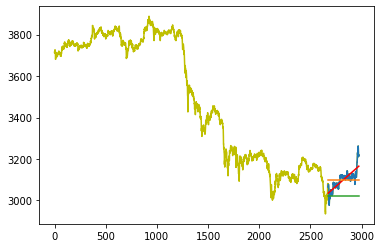

RAD
the current price is too far of the window mean
the conditions have not been met so leave currency out this time
AVAX
the current price is too far of the window mean
the conditions have not been met so leave currency out this time
ENS
start point: 1748
check percent: 0.9918810991268618
-0.005234020772761692
 max: 28.73
 mean: 26.18566101694915
 min: 24.6


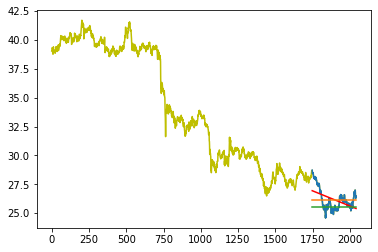

DOT
the current price is too far of the window mean
the conditions have not been met so leave currency out this time
ICP
start point: 2632
check percent: 0.9874007983094623
0.0028171513644284297
 max: 36.97
 mean: 34.90983606557377
 min: 33.1


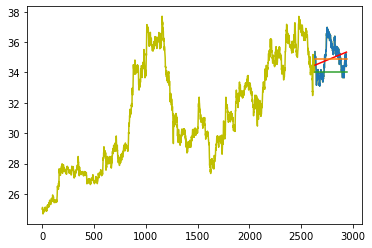

BTRST
start point: -85
check percent: 0.9697088906372934
AXS
start point: 1678
check percent: 0.961775545328694
-0.0035548627146690126
 max: 73.08
 mean: 69.70949152542374
 min: 65.41


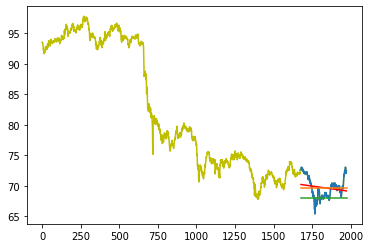

SOL
start point: 2625
check percent: 0.9606112871896856
0.014186469065624516
 max: 142.81
 mean: 136.04177049180328
 min: 131.52


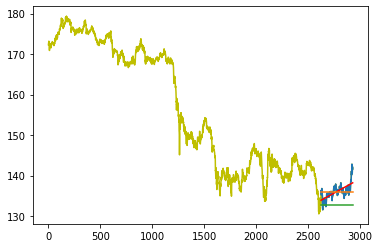

MASK
start point: 1000
check percent: 0.9841008922443376
-0.002430431117909656
 max: 9.81
 mean: 9.250548387096774
 min: 8.42


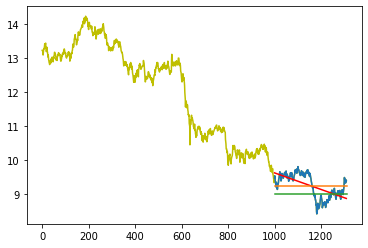

POLY
start point: 1153
check percent: 0.9879283003967593
-0.0001635141679209476
 max: 0.5282
 mean: 0.4816138983050847
 min: 0.4495


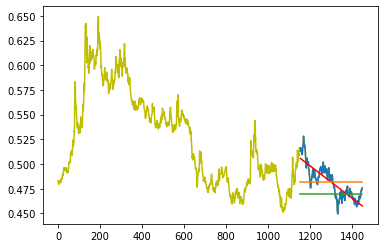

CHZ
start point: 1164
check percent: 0.985979685530103
-1.2800746412900735e-05
 max: 0.269
 mean: 0.2558617283950617
 min: 0.2385


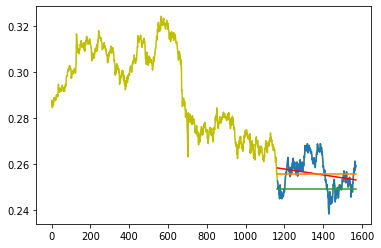

In [199]:
#%%%%%%%%%%%%%%%%%%%%%%%!!!!!!!!!!!!!!!!!!!!!!!!!^^^^^^^^^^^^^^^^^^^^^^
#%%%%%%%%%%%%%%%%%%%%%%%!!!!!!!!!!!!!!!!!!!!!!!!!^^^^^^^^^^^^^^^^^^^^^^
#%%%%%%%%%%%%%%%%%%%%%%%!!!!!!!!!!!!!!!!!!!!!!!!!^^^^^^^^^^^^^^^^^^^^^^
#%%%%%%%%%%%%%%%%%%%%%%%!!!!!!!!!!!!!!!!!!!!!!!!!^^^^^^^^^^^^^^^^^^^^^^
#%%%%%%%%%%%%%%%%%%%%%%%!!!!!!!!!!!!!!!!!!!!!!!!!^^^^^^^^^^^^^^^^^^^^^^

#if true, user has to approve any currency added even if it meets minimum standards
user_input=False


#create my client
auth_client = cbpro.AuthenticatedClient(public,secret,passphrase)

#step 1 get potential currencies
potential_products=get_products()

#step up an list of dictionaries
currency_pool=[]

#step 2 pull history for each one, check to see if it is favorable for trade, and if I approve add it to product pool
to_continue=True

for product in potential_products:
    
    if product!='WCFG': #skips this for now as for some reason coming back with an empty df
        print(product)
        df=coinbase_historical(product+'-USDT')
        #plt.plot(df.Close)
        #plt.show()

        #step 3 weed out the spikes, find the buy line and ask if should be included in the pool
        start_point=find_starting_point(df)


        if start_point>=0:
            next_product=False
            adjust=.975
            zoom=False
            while next_product==False:
               # x,y,regress_values=output_graph(df)
                x1,y1,x2,y2,a,b,regress_values=output_graph(df,start_point)


                if zoom==False:
                    plt.plot(x1,y1,'-y')
                plt.plot(x2,y2)
                plt.plot(x2,regress_values,'-r')
                plt.plot(a,[b,b])
                plt.plot(a,[b*adjust,b*adjust])

                plt.show()

                if user_input==True:
                    approve=input("Do you want to include? (y/n/(z)oom/(a)djust)")
                else:
                    approve='y'

                if approve=='y':
                    currency_pool.append({'CRYPTO':product,'BUY-PRICE':b*adjust,'bought':0,'sell':0,'hold':0})
                    next_product=True
                elif approve=='z':
                    zoom=True
                    clear_output(wait=True)
                elif approve=='a':
                    print('yes')
                    adjust=float(input('enter a number (default .99 of the mean)'))
                    clear_output(wait=True)
                elif approve=='n':
                    clear_output(wait=True)
                    next_product=True
                else:
                    print('not a valid response')
                    
    
    #if user includes, include the buy price for the product
    
    

#%%%%%%%%%%%%%%%%%%%%%%%!!!!!!!!!!!!!!!!!!!!!!!!!^^^^^^^^^^^^^^^^^^^^^^
#%%%%%%%%%%%%%%%%%%%%%%%!!!!!!!!!!!!!!!!!!!!!!!!!^^^^^^^^^^^^^^^^^^^^^^
#%%%%%%%%%%%%%%%%%%%%%%%!!!!!!!!!!!!!!!!!!!!!!!!!^^^^^^^^^^^^^^^^^^^^^^
#%%%%%%%%%%%%%%%%%%%%%%%!!!!!!!!!!!!!!!!!!!!!!!!!^^^^^^^^^^^^^^^^^^^^^^
#%%%%%%%%%%%%%%%%%%%%%%%!!!!!!!!!!!!!!!!!!!!!!!!!^^^^^^^^^^^^^^^^^^^^^^

In [182]:
for currency in currency_pool:
    print(currency['CRYPTO'])

SOL


In [10]:
#sorts through and pics all products that can be traded, that aren't limit only, etc
def get_products():
    my_products=auth_client.get_products()
    avail_products=[]

    for product in my_products:

        if (product['id'].split('-')[1]=='USDT'):
            if (product['cancel_only']==False and product['limit_only']== False and
                product['trading_disabled']== False and product['auction_mode']==False and
                product['fx_stablecoin']==False): 
                avail_products.append(product['id'].split('-')[0])#'trading_disabled''limit_only': True, 'cancel_only':
    #print (avail_products)
    #print (len(avail_products))
    return (avail_products)

In [357]:
product_pool=get_products()

In [362]:
#this will cycle through and I'll have it give the chance to see and then decide to include or not
from IPython.display import clear_output
my_array=[]
for product in product_pool:
    print(product)
    
    clear_output(wait=True)
    keep=input("Keep this? (y/n)")
    if keep=='y':
        my_array.append(product)
    

Keep this? (y/n)n


In [188]:
#for c in currency_pool:
 #   c['sell']=0
  #  if c['hold']==2:
   #     c['hold']=1
    
print(currency_pool)

[{'CRYPTO': 'LCX', 'BUY-PRICE': 0.15764933220338984, 'bought': 0.1571, 'sell': 0, 'hold': 1}, {'CRYPTO': 'DOGE', 'BUY-PRICE': 0.1513652283870968, 'bought': 0.1514, 'sell': 0, 'hold': 2}, {'CRYPTO': 'BICO', 'BUY-PRICE': 3.5740764, 'bought': 3.58, 'sell': 3.5, 'hold': 4}, {'CRYPTO': 'XYO', 'BUY-PRICE': 0.029000050372881357, 'bought': 0.028934, 'sell': 0.029594, 'hold': 4}, {'CRYPTO': 'MDT', 'BUY-PRICE': 0.09188586406779661, 'bought': 0, 'sell': 0, 'hold': 0}, {'CRYPTO': 'POLY', 'BUY-PRICE': 0.4714638885245902, 'bought': 0.4714, 'sell': 0.4797, 'hold': 4}, {'CRYPTO': 'ICP', 'BUY-PRICE': 31.18773593220339, 'bought': 0, 'sell': 0, 'hold': 0}, {'CRYPTO': 'PERP', 'BUY-PRICE': 8.33928910891089, 'bought': 0, 'sell': 0, 'hold': 0}, {'CRYPTO': 'ETH', 'BUY-PRICE': 3048.83931076923, 'bought': 0, 'sell': 0, 'hold': 0}, {'CRYPTO': 'KRL', 'BUY-PRICE': 1.2543119661016948, 'bought': 1.2563, 'sell': 1.2765, 'hold': 4}, {'CRYPTO': 'CHZ', 'BUY-PRICE': 0.24976628474576268, 'bought': 0, 'sell': 0, 'hold': 0}

In [ ]:
#create function that initiates all potential currencies
#append potential currencies once hits certain number? or delete currency if it makes a big swing
#4 slots of currency
#testing out on just the above sample and if it starts to work will apply it to all

count=0
hold=0
active=True
#mean_value=3.449870967741935#df.Close.mean()
#buy_value=.08951741437610206
print(f'median value at start: {mean_value}')
#print(buy_value)
print(count)
while(active):
    
    count=count+1
    if (count>500):
        for c in currency_pool:
            if c['hold']==2:
                print ("------")
                print(c['CRYPTO'])
                print(f'bought price: {c["bought"]}')
                print(f'current price: {ticker_update(c["CRYPTO"]).json()["price"]}')
                print(f'estimated sale price: {c["bought"]*1.02}')
                print ("------")
                print("")
        count=0
    
    for c in currency_pool:
    
        time.sleep(0)



        ticker=float(ticker_update(c['CRYPTO']).json()['price']) 

        #pre-buy
        if (ticker<c['BUY-PRICE'] and c['hold']==0):
            c['bought']=ticker
            c['hold'] = 1
        
        #actual buy
        if (ticker>c['bought'] and c['hold']==1):   
            print('!!!!!!!!!!!!!!!!!')
            print(f'{c["CRYPTO"]} buy at: {ticker}')
            print('!!!!!!!!!!!!!!!!!')
            c['bought']=ticker
            c['hold'] = 2
        
        #pre-sale
        if (ticker>c['bought']*1.03 and c['hold']==2):
            c['sell']=ticker
            c['hold']=3
            #active=False
        
        #actual-sale
        if (ticker<c['sell'] and c['hold']==3):
            print('!!!!!!!!!!!!!!!!!')
            print(f'{c["CRYPTO"]} sell at {ticker}')
            print('!!!!!!!!!!!!!!!!!')
            c['sell']=ticker
            c['hold']=4
            print("!!!!!!!!")
            print(c['sell']/c['bought']*1000)
            print("!!!!!!!!")
            #active=False
        
        #cancel sale (maybe if hold=3 also)
        if (ticker<c['bought']*0 and c['hold']==2):
            print('!!!!!!!!!!!!!!!!!')
            print(f'{c["CRYPTO"]} sell at {ticker}')
            print('!!!!!!!!!!!!!!!!!')
            c['sell']=ticker
            c['hold']=4
            print("!!!!!!!!")
            print(c['sell']/c['bought']*1000)
            print("!!!!!!!!")
            
    
print (f'You made: {sell_value/buy_value*1000}')#buy at .45312

median value at start: 3.449870967741935
0
!!!!!!!!!!!!!!!!!
ORN buy at: 4.74
!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!
AUCTION buy at: 20.06
!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!
VGX buy at: 2.56
!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!
IDEX sell at 0.2127
!!!!!!!!!!!!!!!!!
!!!!!!!!
1027.536231884058
!!!!!!!!
!!!!!!!!!!!!!!!!!
COVAL buy at: 0.10738
!!!!!!!!!!!!!!!!!
------
ASM
bought price: 0.07912
current price: 0.08107
estimated sale price: 0.0807024
------

------
ARPA
bought price: 0.0828
current price: 0.0827
estimated sale price: 0.084456
------

------
COVAL
bought price: 0.10738
current price: 0.10718
estimated sale price: 0.1095276
------

------
MDT
bought price: 0.0902
current price: 0.0883
estimated sale price: 0.092004
------

------
CLV
bought price: 0.58
current price: 0.57
estimated sale price: 0.5916
------

------
AUCTION
bought price: 20.06
current price: 20.02
estimated sale price: 20.461199999999998
------

------
VGX
bought price: 2.56
current price: 2.52
estimated sale price

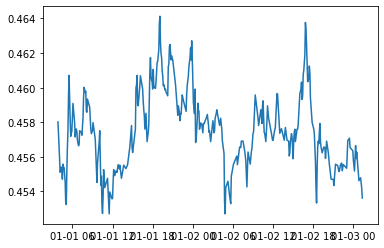

In [297]:
plt.plot(window.Close)

In [237]:
#historical2=historical
#historical2.reset_index(inplace=True) - changed to numbers instead of dates
x = df.index
#x=np.arange(len(historical))
y = df.High
slope, intercept, r_value, p_value, std_err = linregress(x, y)

regress_values=x*slope+intercept
plt.plot(y)
plt.plot(x,regress_values,'-r')
plt.plot(x,regress_values*.965,'-g')
plt.plot(x,regress_values*1.035,'-y')


UFuncTypeError: ufunc 'add' cannot use operands with types dtype('<M8[ns]') and dtype('<M8[ns]')

In [281]:
trunc_df=pd.read_csv("BTC_2021_11_12_coinbase.csv").iloc[0:244] #12 hours
#historical2=historical
#historical2.reset_index(inplace=True) - changed to numbers instead of dates
x = trunc_df.index
#x=np.arange(len(historical))
y = trunc_df.High
slope, intercept, r_value, p_value, std_err = linregress(x, y)

regress_values=x*slope+intercept
plt.plot(y)
plt.plot(x,regress_values,'-r')
plt.plot(x,regress_values*.99,'-g')
plt.plot(x,regress_values*1.01,'-y')

slope

UFuncTypeError: ufunc 'add' cannot use operands with types dtype('<M8[ns]') and dtype('<M8[ns]')

In [3]:
next_time_marker=datetime.now()+timedelta(minutes=5)

new_time=False
if (datetime.now()>=next_time_marker):
    new_time=True
    print('hit new time')
    


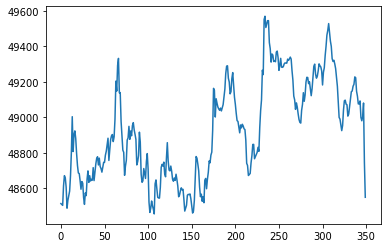

In [98]:
plt.plot(window)

0
request: 0 and new df lenght is 98
request: 1 and new df lenght is 132
request: 2 and new df lenght is 153
request: 3 and new df lenght is 176
request: 4 and new df lenght is 185
request: 5 and new df lenght is 198
198


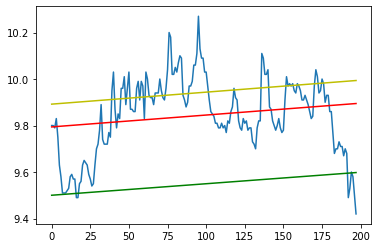


buy price: 9.26
transaction fee$50.0
at: 2021-12-22 17:38:23.998169

time update: 2021-12-22 17:42:09.963257
ticker update: 9.26

updated buy price: $9.598817412551142
updated sell price: $9.9946449347182

time update: 2021-12-22 17:47:12.106571
ticker update: 9.25

updated buy price: $9.599312490076903
updated sell price: $9.995160427812035

time update: 2021-12-22 17:52:17.294434
ticker update: 9.21

updated buy price: $9.599807567602666
updated sell price: $9.995675920905867

time update: 2021-12-22 17:57:18.350800
ticker update: 9.2

updated buy price: $9.600302645128426
updated sell price: $9.996191413999702

time update: 2021-12-22 18:02:20.040785
ticker update: 9.21

updated buy price: $9.600797722654187
updated sell price: $9.996706907093536

time update: 2021-12-22 18:07:21.960727
ticker update: 9.23

updated buy price: $9.60129280017995
updated sell price: $9.99722240018737

time update: 2021-12-22 18:12:22.924342
ticker update: 9.25

updated buy price: $9.60178787770571
upd

KeyboardInterrupt: 

In [271]:
## !!!!!!!!!!!!!!!!
#when it goes into buy it currenlty just doess 5 minutes but the prediction line needs to update every 5 + 10 + 15, etc.
#so predict_line=slope*(len(window)+1)+intercept ... predict_line=slope*(len(window)+2)+intercept
#okay, did it for live but need to update for historical - and should check to make sure it works, gives updates of
#new value to hit every five minutes

#oh and a switch true or false in case need to run without resetting variablesf
#catch error if authentification doesn't work?
#things to experiment with down the line
#will adding an r squared guard help? or help give an adjusted range?
#predict against a giant all - perhaps take out of the line up for awhile?
#slope modifes risk?
#add ticker function above and auth passwords up above
#normalize

restart=False #set this to false on new start or true on crash (for live run only)
print(hold)
if (restart==False):
    hold=0
    total=10000
    fee=0
    fee_rate=.005
    buy_perc=.97
    sell_perc=1.01
    buy_hit_number=0
    sell_hit_number=0


is_live=True

if(is_live):
    if (restart==False):
        #c = cbpro.PublicClient()
        #  right now I manually get the window but I want to add that as a function 
        #444
        #historical = pd.DataFrame(c.get_product_historic_rates(product_id='ETH-USDT', granularity=300))
        #historical.columns= ["Date","Open","High","Low","Close","Volume"]
        #historical['Date'] = pd.to_datetime(historical['Date'], unit='s')
        #historical.set_index('Date', inplace=True)
        #historical.sort_values(by='Date', ascending=True, inplace=True)
        historical=coinbase_historical('PERP-USDT')
        print(len(historical))
    window=historical.High.to_numpy()

        #appends the window every 5 minutes
    next_time_marker=datetime.now()+timedelta(minutes=5)

    
    x = np.arange(0,len(window))
    y = window
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    predict_line=slope*(len(window)+1)+intercept  
    regress_values=x*slope+intercept
    
    plt.plot(x,y)
    plt.plot(x,regress_values,'-r')
    plt.plot(x,regress_values*buy_perc,'-g')
    plt.plot(x,regress_values*sell_perc,'-y')
    plt.show()
    
    auth_client = cbpro.AuthenticatedClient(public,secret,passphrase)
    
    while True:#currently have no exit
        
        
        
        time.sleep(5)
        ticker=float(ticker_update('PERP').json()['price'])  
        

        if (ticker<predict_line*buy_perc and hold==0):
                buy_hit_number=ticker
                hold=1

        if (hold==1 and ticker>buy_hit_number):
            buy_price=ticker
            print('')
            print(f'buy price: {buy_price}')
            print(f'transaction fee${total*fee_rate}')
            print(f'at: {datetime.now()}')
            print('')
            fee=fee+(total*fee_rate)
            count=1
            predict_line=slope*(len(window)+count)+intercept
            hold=2

        else:
            buy_hit_number=ticker

        if (hold==2 and (ticker>predict_line*sell_perc or ticker>buy_price*1.2)):
            sell_hit_number=ticker
            hold=3


        if (hold==3 and ticker<sell_hit_number):
            sell_price=ticker
            print('')
            print(f'sell price: {sell_price}')
            print(f'transaction fee${total*fee_rate}')
            print(f'at: {datetime.now()}')
            print('')
            hold=0

            print('--------------------')
            print(f'You made: ${(sell_price/buy_price*total)-total}')
            total=sell_price/buy_price*total
            fee=fee+(total*fee_rate)
            
            #gets new slope since it hasn't been doing it during the buy sell period
            slope, intercept, r_value, p_value, std_err = linregress(x, y)
            predict_line=slope*(len(window)+1)+intercept
            print(f'new slope: {slope}')
            
        else:
            sell_hit_number=ticker

        #update window and regression line every five minutes or whatever is set above
        if (datetime.now()>=next_time_marker):
            print(f'time update: {datetime.now()}')
            print(f'ticker update: {ticker}')
            
            #resets new time
            next_time_marker=datetime.now()+timedelta(minutes=5)
        
            window = np.delete(window, (0), axis=0)
            window = np.append(window, ticker)
            y = window
             
            if (hold==0):#doesn't update predict line during buy and sell mode       
                slope, intercept, r_value, p_value, std_err = linregress(x, y)
                predict_line=slope*(len(window)+1)+intercept
                print(f'new slope: {slope}')
            else:
                predict_line=slope*(len(window)+count)+intercept
                count=count+1
                print("")
                print(f'updated buy price: ${predict_line*buy_perc}')
                print(f'updated sell price: ${predict_line*sell_perc}')
                print("")


#------------------------------------------------------------------------------    
  

if(is_live==False):
    
    window=historical.iloc[0:4000].High.to_numpy()
    df=historical.iloc[4001:]
    #window=cd.read_csv("BTC_2021_11_12_coinbase.csv").iloc[0:144].High.to_numpy()#or however long
    #df=pd.read_csv("BTC_2021_11_12_coinbase.csv").iloc[len(window):288]

    x = np.arange(0,len(window))
    y = window
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    predict_line=slope*(len(window)+1)+intercept                    
    
    for i, j in df.iterrows():



        if (j.Close<window.mean()*.97):
            buy_hit_number=j.Close
            hold=1

        if (hold==1 and j.Close>buy_hit_number):
            buy_price=j.Close
            print('')
            print(f'buy price: {buy_price}')
            print(f'transaction fee${total*fee_rate}')
            print(f'at: {i}')
            print('')
            fee=fee+(total*fee_rate)
            hold=2

            #regress_values=x*slope+intercept
            #plt.plot(df.Close)
            #plt.plot(x,regress_values,'-r')
            #plt.plot(x,regress_values*.99,'-g')
            #plt.plot(x,regress_values*1.01,'-y')


        else:
            buy_hit_number=j.Close

        if (hold==2 and (j.Close>window.mean()*1.03)):
            sell_hit_number=j.Close
            hold=3


        if (hold==3 and j.Close<sell_hit_number):
            sell_price=j.Close
            print('')
            print(f'sell price: {sell_price}')
            print(f'transaction fee${total*fee_rate}')
            print(f'at: {i}')
            print('')
            hold=0

            print('--------------------')
            print(f'You made: ${(sell_price/buy_price*total)-total}')
            total=sell_price/buy_price*total
            fee=fee+(total*fee_rate)
            
            #gets new slope since it hasn't been doing it during the buy sell period
            slope, intercept, r_value, p_value, std_err = linregress(x, y)
            predict_line=slope*(len(window)+1)+intercept
            print(f'new slope: {slope}')
            count=0
            
        else:
            sell_hit_number=j.Close

        #update window and regression line
        window = np.delete(window, (0), axis=0)
        window = np.append(window, j.Close)
        y = window
        if (hold==0):#doesn't update predict line during buy and sell mode
            slope, intercept, r_value, p_value, std_err = linregress(x, y)
            predict_line=slope*len(window)+intercept

    #if it ends without a sale
    if (hold==10):#change this to 0 if want to have it sell at end of df
        sell_price=j.Close
        sell_price=j.Close
        print('')
        print(f'sell price: {sell_price}')
        print(f'transaction fee${total*fee_rate}')
        print(f'at: {i}')
        print('')
        hold=0

        print('--------------------')
        print(f'You made: ${(sell_price/buy_price*total)-total}')
        total=sell_price/buy_price*total
        fee=fee+(total*fee_rate)
        print('ditch sell')
    


    print('--------------------')
    print('--------------------')
    print(f'final total is ${total}')
    print(f'final fee is ${fee}')
    print(f'You made ${total-fee}')
    print('--------------------')
    print('--------------------')



ValueError: x and y must have same first dimension, but have shapes (4099,) and (197,)

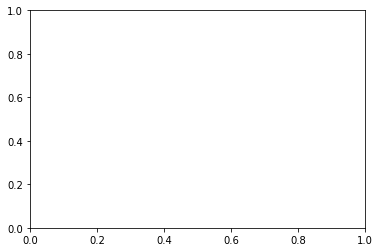

In [269]:
## t = np.arange(0,len(window)+len(df.High))
b = np.concatenate((window,df.High))

x = np.arange(0,len(window))
y = window
slope, intercept, r_value, p_value, std_err = linregress(x, y)
predict_line=slope*(len(window)+1)+intercept 


regress_values=x*slope+intercept
plt.plot(t,b)
plt.plot(x,regress_values,'-g')
plt.plot(x,regress_values*1.01,'-g')
plt.plot(x,regress_values*1.03,'-g')
slope

x = np.arange(len(window),len(window)+len(df.High))
y = df.High
slope, intercept, r_value, p_value, std_err = linregress(x, y)
predict_line=slope*(len(window)+1)+intercept 

regress_values=x*slope+intercept
#plt.plot(x,df.High)
plt.plot(x,regress_values,'-r')
plt.plot(x,regress_values*.98,'-r')
plt.plot(x,regress_values*1.02,'-r')
#slope

window.mean()

In [163]:
df

,Open,High,Low,Close,Volume
Date,,,,,
2021-11-26 23:30:00,53635.71,53719.48,53693.44,53715.99,1.030364
2021-11-26 23:35:00,53736.14,53978.28,53750.90,53800.99,3.247215
2021-11-26 23:40:00,53590.99,53855.13,53855.13,53641.33,0.835151
2021-11-26 23:45:00,53560.14,53830.83,53633.69,53795.20,1.734714
2021-11-26 23:50:00,53653.69,53836.24,53827.62,53657.97,0.435639
...,...,...,...,...,...
2021-12-22 11:40:00,48991.63,49092.60,49064.68,48991.63,0.278045
2021-12-22 11:45:00,48949.27,48999.97,48978.93,48969.04,0.819765
2021-12-22 11:50:00,48908.70,48980.79,48980.79,48960.48,1.150554


-0.522580636733936

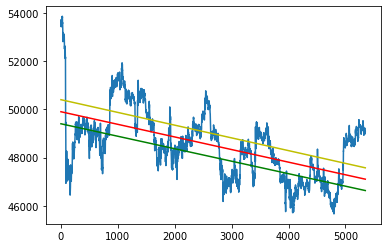

In [135]:
x = np.arange(0,len(df.High))
y = df.High
slope, intercept, r_value, p_value, std_err = linregress(x, y)
predict_line=slope*(len(window)+1)+intercept 

regress_values=x*slope+intercept
plt.plot(x,df.High)
plt.plot(x,regress_values,'-r')
plt.plot(x,regress_values*.99,'-g')
plt.plot(x,regress_values*1.01,'-y')
slope

In [1192]:
df=historical
#can upload this: 'dec_2_spike_kmd.csv'
#test bot
hold=0#default
buy_price=0 #default
old_price=1.2 #when to buy
sell_price=0 #default
new_high=0 #default
original_spend=5000
spend=original_spend #how much to invest
for i, j in df.iterrows():

    if (j.Close<regress_values*.98 and hold==0):
        buy_price=j.price
        new_high=buy_price
        print(f'num={i}')
        print(j.timestamp)
        hold=1
    if (j.price>new_high):
        new_high=j.price
    if (hold==1 and j.price<=new_high*.96 and j.price>buy_price*1.1):#makes sure there isn't a loss for the sell
        sell_price=j.price
        print(f'num={i}')
        print(j.timestamp)
        hold=2
        
    if (hold==2 and j.price>=new_high*1):
        spend=spend+((sell_price/buy_price)*(spend*.98)-spend)
        buy_price=j.price
        new_high=buy_price
        #I will rebuy here with total .... {(sell_price/buy_price)*(spend*.98)-spend}
        hold=1 
        print(f'num={i}')
        print(j.timestamp)
            
print (buy_price)
print (sell_price)
print (f'You made ${(sell_price/buy_price)*(spend*.98)+spend-original_spend*2}')

#maybe not reinvest all option so if It hits 500 keeps 250 for a guaranteed profit?
#and when it hits check to see if there recent twitter post counts?
#time limit or too low?
#perhaps check to see trend and if it jumps by a percentage even if it isn't a new high? 10%?  track new low after new high and if suddenly it jumps up even if it isn't at new high buy again?
#check predictions? in the api

num=20614
2021-12-02T15:56:40.809Z
num=68625
2021-12-02T17:58:18.47Z
num=76033
2021-12-02T18:01:44.625Z
1.4888
1.4287
You made $1317.4185090772808


In [1191]:

df=pd.read_csv('dec_6_spike_kmd.csv')
#test bot
hold=0#default
buy_price=0 #default
old_price=.86 #when to buy
sell_price=0 #default
new_high=0 #default
original_spend=5000
spend=original_spend #how much to invest
for i, j in df.iterrows():

    if (j.price>old_price and hold==0):
        buy_price=j.price
        new_high=buy_price
        print(f'num={i}')
        print(j.timestamp)
        hold=1
    if (j.price>new_high):
        new_high=j.price
    if (hold==1 and j.price<=new_high*.96 and j.price>buy_price*1.1):#makes sure there isn't a loss for the sell
        sell_price=j.price
        print(f'num={i}')
        print(j.timestamp)
        hold=2
        
    if (hold==2 and j.price>=new_high*1):
        spend=spend+((sell_price/buy_price)*(spend*.98)-spend)
        buy_price=j.price
        new_high=buy_price
        #I will rebuy here with total .... {(sell_price/buy_price)*(spend*.98)-spend}
        hold=1 
        print(f'num={i}')
        print(j.timestamp)
            
print (buy_price)
print (sell_price)
print (f'You made ${(sell_price/buy_price)*(spend*.98)+spend-original_spend*2}')

num=5500
2021-12-06T16:03:52.921Z
num=8457
2021-12-06T16:07:45.348Z
0.8603
0.9531
You made $428.5598047192834


In [ ]:
################## MY MILLIONAIRE BOT #######################

In [718]:
import cbpro

In [737]:
#get available products
pc=cbpro.PublicClient()
results=pc.get_products()
for row in results:
    print(row['id'])

CHZ-USD
PAX-USD
FIL-USD
REN-BTC
PERP-USD
ETH-USDC
NKN-USD
BAT-BTC
CRV-BTC
CTSI-USD
CVC-USDC
FX-USD
STORJ-BTC
ZEC-USD
ZRX-USD
DASH-BTC
AXS-BTC
MASK-USDT
UST-EUR
MASK-USD
LCX-USDT
VGX-USD
MIR-BTC
ADA-EUR
DOGE-USDT
CVC-USD
NU-USD
RAD-USD
BAND-EUR
WLUNA-GBP
ENJ-BTC
LTC-USD
SNX-EUR
NU-GBP
KRL-USDT
NMR-EUR
OMG-EUR
TRAC-USD
NMR-USD
ZRX-EUR
REN-USD
POLY-USD
GTC-USD
YFI-BTC
ALCX-USDT
ETC-BTC
MCO2-USDT
RLY-GBP
LCX-EUR
GRT-USD
UST-USDT
ETH-USDT
CRV-EUR
UMA-EUR
XLM-USD
BCH-BTC
CLV-GBP
ALCX-EUR
SNX-GBP
NMR-BTC
EOS-EUR
XYO-USDT
IOTX-USDT
MANA-ETH
UMA-BTC
TRIBE-USD
DOGE-USD
RAD-GBP
KRL-EUR
OMG-GBP
TRU-USDT
AXS-USD
ETH-BTC
DASH-USD
BTRST-USDT
FIL-EUR
POWR-USDT
RGT-USD
FET-USD
MANA-USDC
LOOM-USDC
ARPA-EUR
FORTH-EUR
STORJ-USD
1INCH-BTC
BAT-EUR
MLN-USD
MIR-GBP
ASM-USD
UNI-USD
BAT-USDC
CRO-EUR
DOGE-GBP
WCFG-GBP
REP-USD
BICO-USD
FOX-USDT
BNT-USD
SOL-GBP
FARM-USDT
MANA-USD
KNC-USD
ZEN-BTC
ETC-USD
AXS-EUR
ENS-USD
ICP-BTC
DDX-USDT
MATIC-USD
IDEX-USD
BTC-USDC
UNI-GBP
ARPA-USD
CGLD-BTC
CHZ-EUR
RAD-EUR
CGLD-GBP


In [353]:
#create my client
auth_client = cbpro.AuthenticatedClient(public,secret,passphrase)

In [354]:
#verify my client
auth_client.get_accounts()

[{'id': '6816884e-323c-4bbe-a17d-19f983531c08',
  'currency': '1INCH',
  'balance': '0.0000000000000000',
  'hold': '0.0000000000000000',
  'available': '0',
  'profile_id': 'e4ceef7d-bf47-4805-9db1-a65dacc3eb24',
  'trading_enabled': True},
 {'id': 'a6c04dbc-7d9d-47ad-9e00-2496e9c83d55',
  'currency': 'AAVE',
  'balance': '0.0000000000000000',
  'hold': '0.0000000000000000',
  'available': '0',
  'profile_id': 'e4ceef7d-bf47-4805-9db1-a65dacc3eb24',
  'trading_enabled': True},
 {'id': 'fd3a3da9-f798-4d37-9a24-95b0e85765a5',
  'currency': 'ACH',
  'balance': '0.0000000000000000',
  'hold': '0.0000000000000000',
  'available': '0',
  'profile_id': 'e4ceef7d-bf47-4805-9db1-a65dacc3eb24',
  'trading_enabled': True},
 {'id': '12e1a26d-c4b6-4de5-a58e-ca617e550262',
  'currency': 'ADA',
  'balance': '0.0000000000000000',
  'hold': '0.0000000000000000',
  'available': '0',
  'profile_id': 'e4ceef7d-bf47-4805-9db1-a65dacc3eb24',
  'trading_enabled': True},
 {'id': '980f54ed-c254-4359-84d1-769f

In [7]:
#function to get floor down to two decimal places
def floor_balance(value):
    return math.floor(value*100)/100

In [9]:
#gets available balance for sell or buy
def get_balance(curr):
    for account in accounts:
        currency=account.get('currency')
        if currency==curr:
            acc_id=account.get('id')
            print(curr)
            print(auth_client.get_account(acc_id))
    return auth_client.get_account(acc_id)['available']

In [10]:
#function to calculate needed value to sell, etc. for bot
def output_req(buy_price,profit_limit,sell_limit):
    purchase=10
    profit_req=buy_price*profit_limit
    high_req =100/(sell_limit*100)*profit_req
    print(f'sell price if only hits minimum: {profit_req}')
    print(f'will at least need to hit this price to auto sell {high_req}')

In [59]:
print(float(ticker_update('ASM').json()['price']))
print(float(ticker_update('POWR').json()['price']))
print(float(ticker_update('DDX').json()['price']))
print(float(ticker_update('SKL').json()['price']))
print(float(ticker_update('MATIC').json()['price']))

0.08979
0.6089
4.44
0.2046
2.3957


In [351]:
def get_products():
    my_products=auth_client.get_products()
    avail_products=[]

    for product in my_products:

        if (product['id'].split('-')[1]=='USDT'):
            if (product['cancel_only']==False and product['limit_only']== False and
                product['trading_disabled']== False and product['auction_mode']==False and
                product['fx_stablecoin']==False): 
                avail_products.append(product['id'].split('-')[0])#'trading_disabled''limit_only': True, 'cancel_only':
    #print (avail_products)
    #print (len(avail_products))
    return (avail_products)

In [355]:
get_products()#DOGE,CRO,CHZ,SPELL,GALA,KRL,TRU,REQ,RLY,WCFG

['ASM',
 'BICO',
 'TRU',
 'CLV',
 'RLY',
 'SUKU',
 'ETH',
 'SOL',
 'BTC',
 'AUCTION',
 'BTRST',
 'XYO',
 'CRO',
 'ENS',
 'REQ',
 'SHIB',
 'AGLD',
 'WLUNA',
 'GALA',
 'VGX',
 'ARPA',
 'RAD',
 'DDX',
 'ORN',
 'MCO2',
 'ICP',
 'COVAL',
 'MASK',
 'MDT',
 'DOT',
 'TRAC',
 'CHZ',
 'FET',
 'BADGER',
 'KRL',
 'POLS',
 'PERP',
 'AXS',
 'IDEX',
 'ALCX',
 'SPELL',
 'DOGE',
 'LCX',
 'WCFG',
 'POLY',
 'AVAX']

In [1503]:
def normalize(values):
    return (values - values.min())/(values.max() - values.min())
    #return (values - values.min())/(values.max() - values.min())

In [1499]:
y=normalize(pd.DataFrame({'temp':[.1677,.1781]}))
slope, intercept, r_value, p_value, std_err = linregress([0,1],y.temp)
slope

0.01040000000000002

In [1498]:
slope

0.0

In [177]:
float(ticker_update('BTC').json()['price'])

46850.35

In [ ]:
### add an eject button if it hits too low!
#MILLIONAIR BOT

auth_client = cbpro.AuthenticatedClient(public,secret,passphrase)
first_run=True #set this to false if cell is interuppted and I want to continue where left off
is_live=False #won't actually buy or sell


#creates a general array for y to help figure out slope of product
win_index=[]#length of the array for window #time sleep every one second then this is about 3 1/2 minutes - corresponds with time below
for i in range(0,90):
    win_index.append(i)


#the possible products    
the_products=get_products()
product_pool={}

for product in the_products:
    product_pool[product]=[]
    
#so! now I need to have it cycle through all available products and each time one matches
#the requirements, it buys and is moved into an available dictionary INCLUDING THE WINDOW
#after it sells it is moved back into circulation
#including the additional funds and the spend adjusts accordingly
        
#!!!! Temporarily overrides the entire product pool until I can find a faster way to cycle through
#the_products=['DOGE','CRO','CHZ','SPELL','GALA','TRU','REQ','RLY','WCFG']
#product_pool={'DOGE':[],'CRO':[],'CHZ':[],'SPELL':[],'GALA':[],'TRU':[],'REQ':[],'RLY':[],'WCFG':[]}    

#initializes the bots - might just be able to do one at a time unless find a way to further limit but for now 1
if (first_run==True):
    dict1 = {'crypto': '', 'hold':0,'buy_price':0 ,'new_high':0,'spend':0,'window':[]}
    #dict2 = {'crypto': '', 'hold':0,'buy_price':0 ,'new_high':0,'spend':0}
    #dict3 = {'crypto': '', 'hold':0,'buy_price':0 , 'new_high':0,'spend':0}
    #dict4 = {'crypto': '', 'hold':0,'buy_price':0 , 'new_high':0,'spend':0}
    
    currencies=[dict1] #start with just 1
    
    available_slots=len(currencies) #match the number of dictionaries possible
    
    hold=0 #0=initial, 1=hold, 2=sold (back to 0 to be put back in circulation)
    
    profit_limit=1 #sets the desired profit before selling
    sell_limit=.98 #will sell if the high price drops to this percentage (if profit limit is met too)
    #high_increase=1.0 #will buy again if price hits the current high multiplied by this
    
    #sets the spend value for each dictionary

    
print ('Bot Started!')
bot_count=0
hit_window=False
    
while True:#currently this keeps running until manually exiting
    
    
    
    
    auth_client = cbpro.AuthenticatedClient(public,secret,passphrase)
    
    #for product in the_products:
        
    price=float(ticker_update('GALA').json()['price'])
      #  product_pool[product].append(price)
        
        #bot_count=bot_count+1
        #if (bot_count==12):
         #   print(f'{product} price update at:{price} - to make sure is still live')
          #  print(len(product_pool[product]))
           # bot_count=0

        #if (len(product_pool[product])>=90):
            #print('yes')
         #   if (hit_window==False):
          #      hit_window=True
           #     print ('Let us get those buys!')
            #x = win_index
            #y = pd.DataFrame({'temp':product_pool[product]}).temp
            
            
            #!!!!!!!! THIS IS MAKING IT GO SLOW!
            #slope, intercept, r_value, p_value, std_err = linregress(x, normalize(y))
            #print(slope)
            #product_pool[product].pop(0)

    in_circulation=True

    #if not in circulation sees if a slot is available for another purchase
    #empty_slot=0 #if 0 there is no available slots for a new purchase
    #slot_count=0
    #the_slot=-1

    #for currency in currencies:

     #   if (currency['crypto']==product): #LINE 74
      #      in_circulation=True
       # if (currency['crypto']==''):
        #    the_slot=slot_count
        #slot_count=slot_count+1


    if (in_circulation==True):
        type_crypto='GALA'
        type_exchange=type_crypto+'-USDT'
        buy_price=currencies[the_slot]['buy_price']
        new_high=currencies[the_slot]['new_high']
        spend=currencies[the_slot]['spend']
        hold=currencies[the_slot]['hold']

    #check to see if it is already bought and in current circulation
    if (hold==0): ##just works with under 1 dollar for now
        #if (the_slot!=-1):
         #   currencies[the_slot]['crypto']=product #adds to the slot


        if (is_live==True):
            original_spend=float(get_balance('USDT')) #amount to spend initially on first buy
        else:
            original_spend=1000

        #currencies[the_slot]['spend']=original_spend/available_slots

        #in_circulation=True
        #available_slots=available_slots-1

        buy_price=price
        new_high=buy_price
        print('')
        print('PURCHASE ORDER:')
        print(f'date: {datetime.now()}')
        print (f'{type_crypto} :${price}')
        #print(f'buy slope: {slope}')
        #print(f'buy r squared: {r_value*r_value}')
        print('')
        print(output_req(buy_price,profit_limit,sell_limit))
        print('')

        if (is_live==True):
            the_bought=(auth_client.place_market_order(type_exchange, 'buy', funds=floor_balance(spend)))

            #checks to see if buy goes through
            if (len(the_bought)==1):
                print (the_bought)
                currencies[the_slot]['spend']=0
                currencies[the_slot]['crypto']=''
                hold=0
                print ('the buy did not go through')
            else:
                output_req(buy_price,profit_limit,sell_limit)
                currencies[the_slot]['hold']=1



    active=True
    while (active==True):
        
        price=float(ticker_update('ASM').json()['price'])

        if (price>new_high):
            new_high=price
            print(new_high)

        if (hold==1 and ((price<=new_high*sell_limit and price>buy_price*profit_limit))):#makes sure there isn't a loss for the sell
            print('')
            print('SELL ORDER:')
            print(f'date: {datetime.now()}')
            print(f'sell price: {price}')
            print(f'sell slope: {slope}')
            print(f'sell r squared: {r_value*r_value}')
            print('')

            if (is_live==True):
                print(auth_client.place_market_order(type_exchange, 'sell', size=floor_balance(float(get_balance(type_crypto)))))
            active=False


    #reset values
    currencies[the_slot]['crypto']=''
    currencies[the_slot]['hold']=0
    currencies[the_slot]['hold']=0
    currencies[the_slot]['new_high']=0
    currencies[the_slot]['spend']=0
    available_slots=available_slots+1

    #back_up values before moving to next currency when several are active but that is not the case now
    #if (currencies[the_slot]!=''):
    #   currencies[the_slot]['buy_price']=buy_price
    #currencies[the_slot]['new_high']=new_high
    #currencies[the_slot]['spend']=spend
    #currencies[the_slot]['hold']=hold


Bot Started!

PURCHASE ORDER:
date: 2021-12-12 08:03:27.789083
GALA :$0.57559

sell price if only hits minimum: 0.57559
will at least need to hit this price to auto sell 0.5873367346938776
None



In [1507]:
len(product_pool[product])

89

In [1189]:
#manually sell my current one
#print(auth_client.place_market_order('MASK-USDT', 'sell', size=floor_balance(float(get_balance('MASK')))))

MASK
{'id': 'f8765463-bde3-4c7c-8c92-4484ba10d156', 'currency': 'MASK', 'balance': '0.9200000000000000', 'hold': '0.0000000000000000', 'available': '0.92', 'profile_id': 'e4ceef7d-bf47-4805-9db1-a65dacc3eb24', 'trading_enabled': True}
{'id': '52125c98-1635-47c0-b4d3-072c04e125fa', 'size': '0.92', 'product_id': 'MASK-USDT', 'side': 'sell', 'stp': 'dc', 'type': 'market', 'post_only': False, 'created_at': '2021-12-10T03:05:23.87493Z', 'fill_fees': '0', 'filled_size': '0', 'executed_value': '0', 'status': 'pending', 'settled': False}


In [857]:
#manually buy
#auth_client.place_market_order('BTC-USDT', 'buy', funds=5)

{'id': '2b89d592-6411-45d2-a397-6bc07c39985b',
 'product_id': 'BTC-USDT',
 'side': 'buy',
 'stp': 'dc',
 'funds': '4.97512437',
 'specified_funds': '5',
 'type': 'market',
 'post_only': False,
 'created_at': '2021-12-08T21:50:28.975657Z',
 'fill_fees': '0',
 'filled_size': '0',
 'executed_value': '0',
 'status': 'pending',
 'settled': False}

In [1350]:
#manually sell 
#a=auth_client.place_market_order('DDX-USDT', 'sell', funds=1)


In [362]:
k=[1,2,3,4,5]
j=[10,20,30,40,50]

In [367]:
slope*5.5+intercept

55.0

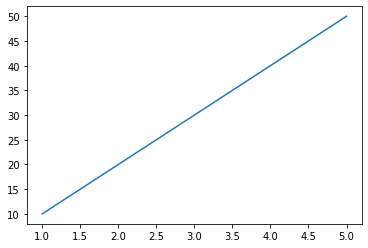

In [363]:
test_df=pd.DataFrame(j,k)

test_df.reset_index(inplace=True)
test_df.columns=['num','score']
test_df
slope, intercept, r_value, p_value, std_err = linregress(test_df['num'], test_df['score'])

regress_values=test_df['score']*slope+intercept
plt.plot(test_df['num'],test_df['score'])
#plt.plot(test_df['score'],regress_values,'-r')
#plt.plot(test_df['score'],regress_values*.96,'-g')
#plt.plot(test_df['score'],regress_values*1.04,'-y')

In [354]:
test_df=pd.DataFrame(j,k)

test_df.reset_index(inplace=True)
test_df.columns=['num','score']
test_df
slope, intercept, r_value, p_value, std_err = linregress(test_df['num'], test_df['score'])

In [35]:
a=[0,5]
a.append(10)
a

[0, 5, 10]

In [36]:
b=a.pop(0)

In [38]:
a

[5, 10]

In [44]:
window

,Unnamed: 0,level_0,index,Date,Open,High,Low,Close,Volume
0,0,0,0,2021-11-16 20:00:00,59893.35,60188.69,60188.68,59992.99,0.704041
1,1,1,1,2021-11-16 20:05:00,59979.60,60159.92,59997.95,60030.96,1.263909
2,2,2,2,2021-11-16 20:10:00,59837.59,60007.35,59987.24,59905.54,7.138614
3,3,3,3,2021-11-16 20:15:00,59600.89,59902.56,59902.56,59770.55,3.807446
4,4,4,4,2021-11-16 20:20:00,59708.14,59876.64,59771.78,59711.45,0.899153
...,...,...,...,...,...,...,...,...,...
239,239,239,239,2021-11-17 15:55:00,59589.08,59691.16,59591.00,59650.03,0.414862
240,240,240,240,2021-11-17 16:00:00,59423.82,59683.72,59666.23,59439.02,0.305816
241,241,241,241,2021-11-17 16:05:00,59427.28,59625.56,59450.29,59625.56,5.341838
242,242,242,242,2021-11-17 16:10:00,59512.51,59887.98,59600.10,59887.98,1.102823


In [ ]:
window